# Building a VAE for the Omniglot Dataset

I chose Omniglot because it has small and structured images that should let a VAE learn meaningful manifolds quickly while offering more diversity than MNIST (see refernece [1][2]).

In [31]:
# Download Omniglot dataset

# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Binarization 
class Binarize(object):
    def __call__(self, tensor):
        return (tensor > 0.5).float()

# Transform to resize, convert to tensor, and binarize
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    Binarize(),
])

# Download train and test sets
train_dataset = datasets.Omniglot(root='data_omniglot',
                                  background=True,
                                  download=True,
                                  transform=transform)
test_dataset  = datasets.Omniglot(root='data_omniglot',
                                  background=False,
                                  download=True,
                                  transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader  = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False)


## Model Implementation and Training (see reference [3])

> Note that the code below is adapted from reference [3] which was originaly for tensorflow and the MNIST Dataset

In [32]:
# CVAE model definition

import torch.nn as nn

class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, latent_dim * 2),  # mean and logvar
        )

        # Decoder input projection -> This was moved outside self.decoder to avoid meeding a helper class
        self.decoder_input = nn.Linear(latent_dim, 7 * 7 * 32)
        # Decoder
        self.decoder = nn.Sequential(
            # will reshape to (B, 32, 7, 7)
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7 -> 14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14 -> 28
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # 28x28 output logits
        )

    def sample(self, eps=None):
        if eps is None:
            device = next(self.parameters()).device
            eps = torch.randn(100, self.latent_dim, device=device)
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(mean)
        return eps * torch.exp(0.5 * logvar) + mean

    def decode(self, z, apply_sigmoid=False):
        h = self.decoder_input(z)
        h = h.view(-1, 32, 7, 7)
        logits = self.decoder(h)
        if apply_sigmoid:
            return torch.sigmoid(logits)
        return logits



In [33]:
# Loss, optimizer, and training step setup

import torch.nn.functional as F
import numpy as np

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set the dimensionality of the latent space 
latent_dim = 512

# Initialize model and optimizer
model = CVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Log normal pdf
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = torch.log(torch.tensor(2.0 * np.pi, device=sample.device))
    return torch.sum(
        -0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi),
        dim=raxis
    )

# Compute ELBO loss 
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = F.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
    logpx_z = -torch.sum(cross_ent, dim=[1, 2, 3])
    logpz = log_normal_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x = log_normal_pdf(z, mean, logvar)
    elbo = logpx_z + logpz - logqz_x
    loss = -torch.mean(elbo)
    return loss

# Single training step
def train_step(model, x, optimizer):
    model.train()
    x = x.to(device)
    optimizer.zero_grad()
    loss = compute_loss(model, x)
    loss.backward()
    optimizer.step()
    return loss


Epoch: 1, Test set ELBO: -170.0066, time elapse for current epoch: 7.02
Epoch: 2, Test set ELBO: -160.3333, time elapse for current epoch: 7.11
Epoch: 3, Test set ELBO: -155.0893, time elapse for current epoch: 6.92
Epoch: 4, Test set ELBO: -151.2343, time elapse for current epoch: 7.04
Epoch: 5, Test set ELBO: -148.2372, time elapse for current epoch: 7.08
Epoch: 6, Test set ELBO: -145.3359, time elapse for current epoch: 7.19
Epoch: 7, Test set ELBO: -142.5173, time elapse for current epoch: 6.73
Epoch: 8, Test set ELBO: -140.6993, time elapse for current epoch: 7.00
Epoch: 9, Test set ELBO: -138.5511, time elapse for current epoch: 6.89
Epoch: 10, Test set ELBO: -136.8014, time elapse for current epoch: 6.74


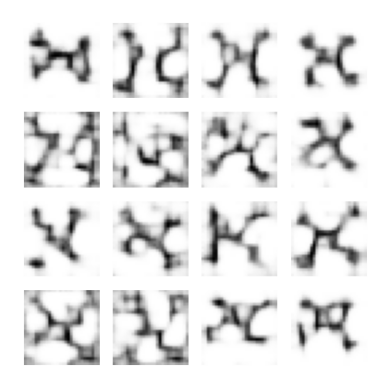

C:\Users\kylej\AppData\Local\Temp\ipykernel_20824\3468089797.py:75: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
# Training loop, generation, and visualization helpers

import time
import glob
import imageio
import matplotlib.pyplot as plt
from PIL import Image

# set the dimensionality of the latent space 
num_examples_to_generate = 16 
random_vector_for_generation = torch.randn(num_examples_to_generate, latent_dim).to(device)

# Pick a sample of the test set for generating output images
test_iter = iter(test_loader)
test_batch, _ = next(test_iter)
assert test_batch.shape[0] >= num_examples_to_generate
test_sample = test_batch[0:num_examples_to_generate].to(device)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_sample, path_template='image_at_epoch_{:04d}.png'):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z) 
        preds = predictions.cpu().numpy()

    fig = plt.figure(figsize=(4, 4))
    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(preds[i, 0, :, :], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    fname = path_template.format(epoch)
    plt.savefig(fname)
    plt.close(fig)

# Initial generation before training
generate_and_save_images(model, 0, test_sample)

# Training epochs
epochs = 10
for epoch in range(1, epochs + 1):
    start_time = time.time()
    # training
    for train_batch, _ in train_loader:
        _ = train_step(model, train_batch, optimizer)
    end_time = time.time()

    # evaluation on test set to compute ELBO
    loss_accum = []
    model.eval()
    with torch.no_grad():
        for test_batch, _ in test_loader:
            test_batch = test_batch.to(device)
            loss = compute_loss(model, test_batch)
            loss_accum.append(loss.cpu())
    mean_loss = torch.stack(loss_accum).mean()
    elbo = -mean_loss 

    print(f"Epoch: {epoch}, Test set ELBO: {elbo:.4f}, time elapse for current epoch: {end_time - start_time:.2f}")
    generate_and_save_images(model, epoch, test_sample)

# Display a generated image from the last training epoch
img = Image.open(f'image_at_epoch_{epochs:04d}.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Create GIF of saved images
anim_file = 'cvae_omniglot.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(glob.glob('image_at_epoch_*.png'))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # repeat last frame
    writer.append_data(image)


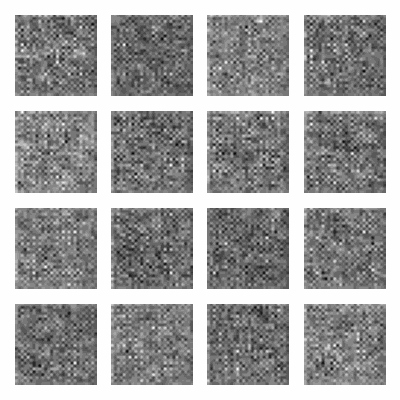

In [ ]:
# Visualise GIF file

import glob
import imageio.v2 as imageio  
from IPython.display import Image, display

filenames = sorted(glob.glob('image_at_epoch_*.png'))
frame_duration = 1000  

# Print Gif
with imageio.get_writer('cvae_omniglot_slow.gif', mode='I', loop=0, duration=frame_duration) as writer:
    for filename in filenames:
        img = imageio.imread(filename)
        writer.append_data(img)
    writer.append_data(img)

display(Image(filename='cvae_omniglot_slow.gif', width=400))



## GAN implementation (see reference [4])

Now we will do the same task with a GAN adapting the code in reference[4]

In [85]:
# Download Omniglot dataset for GAN

# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to resize, convert to tensor, and normalize to [-1, 1] 
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),          
    transforms.Normalize((0.5,), (0.5,)),
])

# Download train set 
train_dataset = datasets.Omniglot(root='data_omniglot',
                                  background=True,
                                  download=True,
                                  transform=transform)

# Create DataLoader
batch_size = 256 
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)


In [121]:
# Create the generator, discriminator and loss/optimizers

import torch
import torch.nn as nn
import torch.nn.functional as F

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Noise / seed setup 
noise_dim = 100
num_examples_to_generate = 16
seed = torch.randn(num_examples_to_generate, noise_dim, device=device)

# Generator 
def make_generator_model():
    model = nn.Sequential(
        nn.Linear(noise_dim, 7 * 7 * 256, bias=False),
        nn.BatchNorm1d(7 * 7 * 256),
        nn.LeakyReLU(0.2),
        nn.Unflatten(1, (256, 7, 7)),
        nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),  # 7x7 -> 7x7
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),  # 7x7 -> 14x14
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),  # 14x14 -> 28x28
        nn.Tanh()  # output in [-1,1]
    )
    return model

# Discriminator 
def make_discriminator_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),  # 28x28 -> 14x14
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # 14x14 -> 7x7
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.Linear(7 * 7 * 128, 1)  # output logits
    )
    return model

generator = make_generator_model().to(device)
discriminator = make_discriminator_model().to(device)

# Loss function
cross_entropy = nn.BCEWithLogitsLoss()

def discriminator_loss(real_output, fake_output):
    real_labels = torch.ones_like(real_output, device=device)
    fake_labels = torch.zeros_like(fake_output, device=device)
    real_loss = cross_entropy(real_output, real_labels)
    fake_loss = cross_entropy(fake_output, fake_labels)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    target_labels = torch.ones_like(fake_output, device=device)  
    return cross_entropy(fake_output, target_labels)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.999))

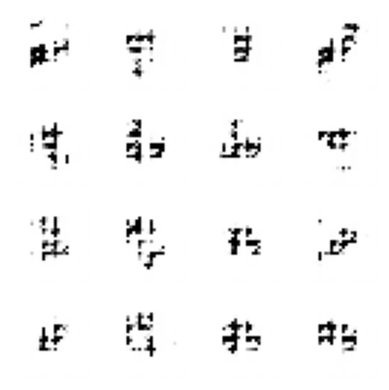

Epoch: 50, Generator loss: 1.8223, Discriminator loss: 0.9983, time elapse for current epoch: 7.28


In [122]:
# Train

#Imports 
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

# generate and save images 
def generate_and_save_images(model, epoch, test_input):
    model.eval()
    with torch.no_grad():
        predictions = model(test_input) 
        imgs = (predictions * 127.5 + 127.5).cpu().numpy().astype("uint8")  

    fig = plt.figure(figsize=(4, 4))
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imgs[i, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# single training step
def train_step(images):
    noise = torch.randn(batch_size, noise_dim, device=device)

    # Generate fake images
    generated_images = generator(noise)

    # Discriminator update
    real_output = discriminator(images)
    fake_output_for_disc = discriminator(generated_images.detach())
    disc_loss = discriminator_loss(real_output, fake_output_for_disc)

    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    # Generator update
    fake_output_for_gen = discriminator(generated_images)
    gen_loss = generator_loss(fake_output_for_gen)

    generator_optimizer.zero_grad()
    gen_loss.backward()
    generator_optimizer.step()

    return gen_loss, disc_loss

# training loop
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        gen_loss_accum = 0.0
        disc_loss_accum = 0.0
        count = 0

        for image_batch, _ in dataset:
            image_batch = image_batch.to(device)
            g_loss, d_loss = train_step(image_batch)
            gen_loss_accum += g_loss.item() if isinstance(g_loss, torch.Tensor) else g_loss
            disc_loss_accum += d_loss.item() if isinstance(d_loss, torch.Tensor) else d_loss
            count += 1

        avg_gen = gen_loss_accum / count
        avg_disc = disc_loss_accum / count
        elapsed = time.time() - start_time

        clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)
        print(f"Epoch: {epoch}, Generator loss: {avg_gen:.4f}, Discriminator loss: {avg_disc:.4f}, time elapse for current epoch: {elapsed:.2f}")

# Run training
EPOCHS = 50
train(train_loader, EPOCHS)


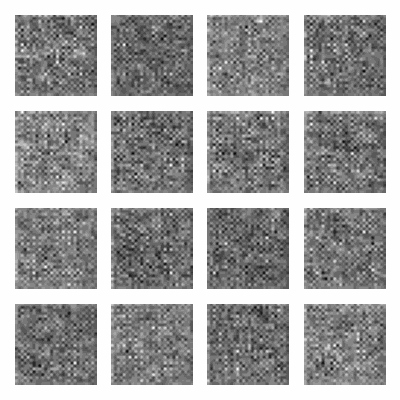

In [125]:
# Visualise GIF file

import glob
import imageio.v2 as imageio  
from IPython.display import Image, display

filenames = sorted(glob.glob('image_at_epoch_*.png'))
frame_duration = 100 

# Print Gif
with imageio.get_writer('dcgan_omniglot_slow.gif', mode='I', loop=0, duration=frame_duration) as writer:
    for filename in filenames:
        img = imageio.imread(filename)
        writer.append_data(img)
    writer.append_data(img)

display(Image(filename='dcgan_omniglot_slow.gif', width=400))


## References

1. Torchvision. (n.d.). *torchvision.datasets.Omniglot documentation*.  
   Retrieved from https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Omniglot.html

2. Lake, B. et al. (n.d.). *Omniglot: A dataset of handwritten characters* (official repo).  
   Retrieved from https://github.com/brendenlake/omniglot

3. TensorFlow Core. (n.d.). *Convolutional Variational Autoencoder tutorial*.  
   Retrieved from https://www.tensorflow.org/tutorials/generative/cvae#display_a_2d_manifold_of_digits_from_the_latent_space

4. TensorFlow. (2024, August 16). *Deep Convolutional Generative Adversarial Network: Save checkpoints*.  
   Retrieved from https://www.tensorflow.org/tutorials/generative/dcgan#save_checkpoints
